Generative Adversarial Networks (GANs)
======================================
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder. If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [ ]:
import sys

In [ ]:
# install pytorch (http://pytorch.org/) and tqdm if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118  #uncomment to enforce cuda 11.8
if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm

%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"Using Pytorch {torch.__version__}.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

Parameter Settings
-------------------


In [ ]:
latent_dim = 10       # latent dimension
num_epochs = 100       # number of training epochs
batch_size = 512      # batch size (you may increase it to gain time, but check not to
                      # exceed your GPU memory limit)
learning_rate = 1e-3  # learning rate of the training algorithm
use_gpu = True        # use the GPU (strongly recommended for speed)
compile = False       # not well implemented on Colab (requires a personal installation with a
                      # relatively recent CUDA-compatible GPU)

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mnist_dims = train_dataloader.dataset[0][0].shape[1:]
mnist_dim = train_dataloader.dataset[0][0].numel()

Vanilla GAN
-----------
We define here the architecture of the different elements of the model. The init defines the different layers and the forward defines what happens when the model is called. We refer to it as the vanilla GAN as it the model in a very simple form.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, mnist_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))
        return x.view(-1, *mnist_dims)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(mnist_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

We can now instantiate and load the model onto the GPU if relevant.

In [ ]:
generator = Generator()
discriminator = Discriminator()

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))


Using the GPU (faster).
Number of parameters for generator: 1463312 and discriminator: 1460225


Training
--------
Be careful, the training can be relatively long, even with a GPU on Colab.

In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1: 100%|██████████| 118/118 [00:06<00:00, 17.69it/s]


	Average loss generator vs. discrim.: 0.841 vs. 0.712


Epoch 2: 100%|██████████| 118/118 [00:06<00:00, 18.07it/s]


	Average loss generator vs. discrim.: 0.846 vs. 0.693


Epoch 3: 100%|██████████| 118/118 [00:06<00:00, 17.94it/s]


	Average loss generator vs. discrim.: 0.845 vs. 0.693


Epoch 4: 100%|██████████| 118/118 [00:06<00:00, 18.06it/s]


	Average loss generator vs. discrim.: 0.86 vs. 0.685


Epoch 5: 100%|██████████| 118/118 [00:06<00:00, 17.88it/s]


	Average loss generator vs. discrim.: 0.89 vs. 0.674


Epoch 6: 100%|██████████| 118/118 [00:06<00:00, 17.70it/s]


	Average loss generator vs. discrim.: 0.923 vs. 0.659


Epoch 7: 100%|██████████| 118/118 [00:06<00:00, 17.95it/s]


	Average loss generator vs. discrim.: 0.954 vs. 0.668


Epoch 8: 100%|██████████| 118/118 [00:06<00:00, 18.08it/s]


	Average loss generator vs. discrim.: 0.986 vs. 0.651


Epoch 9: 100%|██████████| 118/118 [00:06<00:00, 18.02it/s]


	Average loss generator vs. discrim.: 1.02 vs. 0.65


Epoch 10: 100%|██████████| 118/118 [00:06<00:00, 18.04it/s]


	Average loss generator vs. discrim.: 1.07 vs. 0.624


Epoch 11: 100%|██████████| 118/118 [00:06<00:00, 18.03it/s]


	Average loss generator vs. discrim.: 1.13 vs. 0.628


Epoch 12: 100%|██████████| 118/118 [00:06<00:00, 17.99it/s]


	Average loss generator vs. discrim.: 1.15 vs. 0.612


Epoch 13: 100%|██████████| 118/118 [00:06<00:00, 17.59it/s]


	Average loss generator vs. discrim.: 1.22 vs. 0.596


Epoch 14: 100%|██████████| 118/118 [00:06<00:00, 17.81it/s]


	Average loss generator vs. discrim.: 1.32 vs. 0.575


Epoch 15: 100%|██████████| 118/118 [00:06<00:00, 18.07it/s]


	Average loss generator vs. discrim.: 1.33 vs. 0.56


Epoch 16: 100%|██████████| 118/118 [00:06<00:00, 18.24it/s]


	Average loss generator vs. discrim.: 1.39 vs. 0.548


Epoch 17: 100%|██████████| 118/118 [00:06<00:00, 18.10it/s]


	Average loss generator vs. discrim.: 1.42 vs. 0.536


Epoch 18: 100%|██████████| 118/118 [00:06<00:00, 17.95it/s]


	Average loss generator vs. discrim.: 1.45 vs. 0.526


Epoch 19: 100%|██████████| 118/118 [00:06<00:00, 17.97it/s]


	Average loss generator vs. discrim.: 1.51 vs. 0.509


Epoch 20: 100%|██████████| 118/118 [00:06<00:00, 17.64it/s]


	Average loss generator vs. discrim.: 1.54 vs. 0.512


Epoch 21: 100%|██████████| 118/118 [00:06<00:00, 18.17it/s]


	Average loss generator vs. discrim.: 1.62 vs. 0.494


Epoch 22: 100%|██████████| 118/118 [00:06<00:00, 18.19it/s]


	Average loss generator vs. discrim.: 1.65 vs. 0.483


Epoch 23: 100%|██████████| 118/118 [00:06<00:00, 18.26it/s]


	Average loss generator vs. discrim.: 1.71 vs. 0.469


Epoch 24: 100%|██████████| 118/118 [00:06<00:00, 17.99it/s]


	Average loss generator vs. discrim.: 1.79 vs. 0.453


Epoch 25: 100%|██████████| 118/118 [00:06<00:00, 18.00it/s]


	Average loss generator vs. discrim.: 1.82 vs. 0.447


Epoch 26: 100%|██████████| 118/118 [00:06<00:00, 18.00it/s]


	Average loss generator vs. discrim.: 1.87 vs. 0.45


Epoch 27: 100%|██████████| 118/118 [00:06<00:00, 17.71it/s]


	Average loss generator vs. discrim.: 1.96 vs. 0.435


Epoch 28: 100%|██████████| 118/118 [00:06<00:00, 17.87it/s]


	Average loss generator vs. discrim.: 1.97 vs. 0.427


Epoch 29: 100%|██████████| 118/118 [00:06<00:00, 18.00it/s]


	Average loss generator vs. discrim.: 1.96 vs. 0.428


Epoch 30: 100%|██████████| 118/118 [00:06<00:00, 18.11it/s]


	Average loss generator vs. discrim.: 2.01 vs. 0.423


Epoch 31: 100%|██████████| 118/118 [00:06<00:00, 18.01it/s]


	Average loss generator vs. discrim.: 2.0 vs. 0.425


Epoch 32: 100%|██████████| 118/118 [00:06<00:00, 18.14it/s]


	Average loss generator vs. discrim.: 2.03 vs. 0.423


Epoch 33: 100%|██████████| 118/118 [00:06<00:00, 17.92it/s]


	Average loss generator vs. discrim.: 1.92 vs. 0.438


Epoch 34: 100%|██████████| 118/118 [00:06<00:00, 17.81it/s]


	Average loss generator vs. discrim.: 2.0 vs. 0.423


Epoch 35: 100%|██████████| 118/118 [00:06<00:00, 18.17it/s]


	Average loss generator vs. discrim.: 2.03 vs. 0.424


Epoch 36: 100%|██████████| 118/118 [00:06<00:00, 18.20it/s]


	Average loss generator vs. discrim.: 2.06 vs. 0.423


Epoch 37: 100%|██████████| 118/118 [00:06<00:00, 18.15it/s]


	Average loss generator vs. discrim.: 2.18 vs. 0.412


Epoch 38: 100%|██████████| 118/118 [00:06<00:00, 18.09it/s]


	Average loss generator vs. discrim.: 2.14 vs. 0.411


Epoch 39: 100%|██████████| 118/118 [00:06<00:00, 18.03it/s]


	Average loss generator vs. discrim.: 2.16 vs. 0.407


Epoch 40: 100%|██████████| 118/118 [00:06<00:00, 17.78it/s]


	Average loss generator vs. discrim.: 2.25 vs. 0.397


Epoch 41: 100%|██████████| 118/118 [00:06<00:00, 17.42it/s]


	Average loss generator vs. discrim.: 2.22 vs. 0.392


Epoch 42: 100%|██████████| 118/118 [00:06<00:00, 17.88it/s]


	Average loss generator vs. discrim.: 2.29 vs. 0.388


Epoch 43: 100%|██████████| 118/118 [00:06<00:00, 18.07it/s]


	Average loss generator vs. discrim.: 2.36 vs. 0.373


Epoch 44: 100%|██████████| 118/118 [00:06<00:00, 18.22it/s]


	Average loss generator vs. discrim.: 2.44 vs. 0.371


Epoch 45: 100%|██████████| 118/118 [00:06<00:00, 17.97it/s]


	Average loss generator vs. discrim.: 2.46 vs. 0.363


Epoch 46: 100%|██████████| 118/118 [00:06<00:00, 17.99it/s]


	Average loss generator vs. discrim.: 2.44 vs. 0.362


Epoch 47: 100%|██████████| 118/118 [00:06<00:00, 17.87it/s]


	Average loss generator vs. discrim.: 2.49 vs. 0.362


Epoch 48: 100%|██████████| 118/118 [00:06<00:00, 17.48it/s]


	Average loss generator vs. discrim.: 2.47 vs. 0.353


Epoch 49: 100%|██████████| 118/118 [00:06<00:00, 17.83it/s]


	Average loss generator vs. discrim.: 2.47 vs. 0.356


Epoch 50: 100%|██████████| 118/118 [00:06<00:00, 17.83it/s]


	Average loss generator vs. discrim.: 2.52 vs. 0.347


Epoch 51: 100%|██████████| 118/118 [00:06<00:00, 18.00it/s]


	Average loss generator vs. discrim.: 2.58 vs. 0.342


Epoch 52: 100%|██████████| 118/118 [00:06<00:00, 17.89it/s]


	Average loss generator vs. discrim.: 2.64 vs. 0.338


Epoch 53: 100%|██████████| 118/118 [00:06<00:00, 17.99it/s]


	Average loss generator vs. discrim.: 2.66 vs. 0.333


Epoch 54: 100%|██████████| 118/118 [00:06<00:00, 17.91it/s]


	Average loss generator vs. discrim.: 2.74 vs. 0.322


Epoch 55: 100%|██████████| 118/118 [00:06<00:00, 17.49it/s]


	Average loss generator vs. discrim.: 2.75 vs. 0.318


Epoch 56: 100%|██████████| 118/118 [00:06<00:00, 17.80it/s]


	Average loss generator vs. discrim.: 2.7 vs. 0.321


Epoch 57: 100%|██████████| 118/118 [00:06<00:00, 17.61it/s]


	Average loss generator vs. discrim.: 2.72 vs. 0.319


Epoch 58: 100%|██████████| 118/118 [00:06<00:00, 17.92it/s]


	Average loss generator vs. discrim.: 2.69 vs. 0.321


Epoch 59: 100%|██████████| 118/118 [00:06<00:00, 17.98it/s]


	Average loss generator vs. discrim.: 2.81 vs. 0.308


Epoch 60: 100%|██████████| 118/118 [00:06<00:00, 18.04it/s]


	Average loss generator vs. discrim.: 2.8 vs. 0.308


Epoch 61: 100%|██████████| 118/118 [00:06<00:00, 17.98it/s]


	Average loss generator vs. discrim.: 2.75 vs. 0.31


Epoch 62: 100%|██████████| 118/118 [00:06<00:00, 17.55it/s]


	Average loss generator vs. discrim.: 2.79 vs. 0.306


Epoch 63: 100%|██████████| 118/118 [00:06<00:00, 17.94it/s]


	Average loss generator vs. discrim.: 2.83 vs. 0.3


Epoch 64: 100%|██████████| 118/118 [00:06<00:00, 18.03it/s]


	Average loss generator vs. discrim.: 2.91 vs. 0.288


Epoch 65: 100%|██████████| 118/118 [00:06<00:00, 18.06it/s]


	Average loss generator vs. discrim.: 2.95 vs. 0.284


Epoch 66: 100%|██████████| 118/118 [00:06<00:00, 18.02it/s]


	Average loss generator vs. discrim.: 2.85 vs. 0.289


Epoch 67: 100%|██████████| 118/118 [00:06<00:00, 18.15it/s]


	Average loss generator vs. discrim.: 2.96 vs. 0.279


Epoch 68: 100%|██████████| 118/118 [00:06<00:00, 18.03it/s]


	Average loss generator vs. discrim.: 2.91 vs. 0.283


Epoch 69: 100%|██████████| 118/118 [00:06<00:00, 17.62it/s]


	Average loss generator vs. discrim.: 2.89 vs. 0.285


Epoch 70: 100%|██████████| 118/118 [00:06<00:00, 18.10it/s]


	Average loss generator vs. discrim.: 2.94 vs. 0.278


Epoch 71: 100%|██████████| 118/118 [00:06<00:00, 17.88it/s]


	Average loss generator vs. discrim.: 2.89 vs. 0.281


Epoch 72: 100%|██████████| 118/118 [00:06<00:00, 17.81it/s]


	Average loss generator vs. discrim.: 2.95 vs. 0.275


Epoch 73: 100%|██████████| 118/118 [00:06<00:00, 17.88it/s]


	Average loss generator vs. discrim.: 2.9 vs. 0.276


Epoch 74: 100%|██████████| 118/118 [00:06<00:00, 18.07it/s]


	Average loss generator vs. discrim.: 3.0 vs. 0.271


Epoch 75: 100%|██████████| 118/118 [00:06<00:00, 18.16it/s]


	Average loss generator vs. discrim.: 3.09 vs. 0.272


Epoch 76: 100%|██████████| 118/118 [00:06<00:00, 17.47it/s]


	Average loss generator vs. discrim.: 3.12 vs. 0.264


Epoch 77: 100%|██████████| 118/118 [00:06<00:00, 18.10it/s]


	Average loss generator vs. discrim.: 3.14 vs. 0.261


Epoch 78: 100%|██████████| 118/118 [00:06<00:00, 18.00it/s]


	Average loss generator vs. discrim.: 3.1 vs. 0.252


Epoch 79: 100%|██████████| 118/118 [00:06<00:00, 18.24it/s]


	Average loss generator vs. discrim.: 3.1 vs. 0.253


Epoch 80: 100%|██████████| 118/118 [00:06<00:00, 18.16it/s]


	Average loss generator vs. discrim.: 3.11 vs. 0.256


Epoch 81: 100%|██████████| 118/118 [00:06<00:00, 18.21it/s]


	Average loss generator vs. discrim.: 3.18 vs. 0.253


Epoch 82: 100%|██████████| 118/118 [00:06<00:00, 17.93it/s]


	Average loss generator vs. discrim.: 3.14 vs. 0.25


Epoch 83: 100%|██████████| 118/118 [00:06<00:00, 17.55it/s]


	Average loss generator vs. discrim.: 3.14 vs. 0.249


Epoch 84: 100%|██████████| 118/118 [00:06<00:00, 17.95it/s]


	Average loss generator vs. discrim.: 3.08 vs. 0.26


Epoch 85: 100%|██████████| 118/118 [00:06<00:00, 18.02it/s]


	Average loss generator vs. discrim.: 3.08 vs. 0.249


Epoch 86: 100%|██████████| 118/118 [00:06<00:00, 18.09it/s]


	Average loss generator vs. discrim.: 3.11 vs. 0.244


Epoch 87: 100%|██████████| 118/118 [00:06<00:00, 18.13it/s]


	Average loss generator vs. discrim.: 3.09 vs. 0.256


Epoch 88: 100%|██████████| 118/118 [00:06<00:00, 17.99it/s]


	Average loss generator vs. discrim.: 3.05 vs. 0.255


Epoch 89: 100%|██████████| 118/118 [00:06<00:00, 18.02it/s]


	Average loss generator vs. discrim.: 3.09 vs. 0.25


Epoch 90: 100%|██████████| 118/118 [00:06<00:00, 17.58it/s]


	Average loss generator vs. discrim.: 3.08 vs. 0.248


Epoch 91: 100%|██████████| 118/118 [00:06<00:00, 18.01it/s]


	Average loss generator vs. discrim.: 3.2 vs. 0.242


Epoch 92: 100%|██████████| 118/118 [00:06<00:00, 17.92it/s]


	Average loss generator vs. discrim.: 3.18 vs. 0.243


Epoch 93: 100%|██████████| 118/118 [00:06<00:00, 18.04it/s]


	Average loss generator vs. discrim.: 3.29 vs. 0.235


Epoch 94: 100%|██████████| 118/118 [00:06<00:00, 18.07it/s]


	Average loss generator vs. discrim.: 3.25 vs. 0.239


Epoch 95: 100%|██████████| 118/118 [00:06<00:00, 17.95it/s]


	Average loss generator vs. discrim.: 3.26 vs. 0.239


Epoch 96: 100%|██████████| 118/118 [00:06<00:00, 18.17it/s]


	Average loss generator vs. discrim.: 3.21 vs. 0.241


Epoch 97: 100%|██████████| 118/118 [00:06<00:00, 17.97it/s]


	Average loss generator vs. discrim.: 3.2 vs. 0.237


Epoch 98: 100%|██████████| 118/118 [00:06<00:00, 18.29it/s]


	Average loss generator vs. discrim.: 3.1 vs. 0.244


Epoch 99: 100%|██████████| 118/118 [00:06<00:00, 18.27it/s]


	Average loss generator vs. discrim.: 3.17 vs. 0.239


Epoch 100: 100%|██████████| 118/118 [00:06<00:00, 18.37it/s]

	Average loss generator vs. discrim.: 3.19 vs. 0.241
Done.


You may save the obtained weights after training.

In [ ]:
import os
if not os.path.exists('./pretrained'):
  os.mkdir('./pretrained')

torch.save(generator.state_dict(), 'my_vanilla_gan_generator.pth')
torch.save(discriminator.state_dict(), 'my_vanilla_gan_discriminator.pth')

If already saved, they can be loaded in the following way.

In [ ]:
# first load your model to generate instances of the generator and discriminator (but don't train it)
generator.load_state_dict(torch.load('my_vanilla_gan_generator.pth'))
discriminator.load_state_dict(torch.load('my_vanilla_gan_discriminator.pth'))

<All keys matched successfully>

Training Curves
---------------

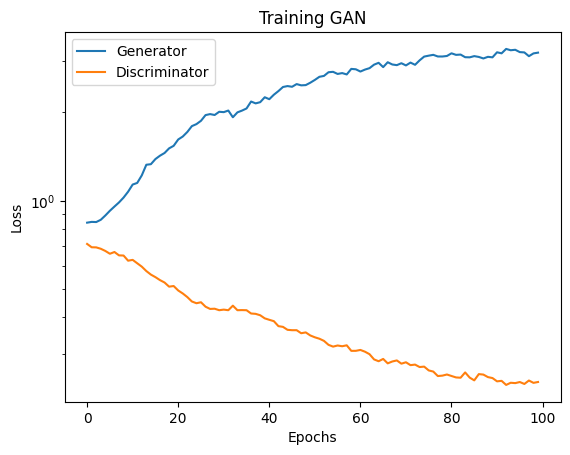

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training GAN')
plt.show()

Interpolate in Latent Space
----------------------------

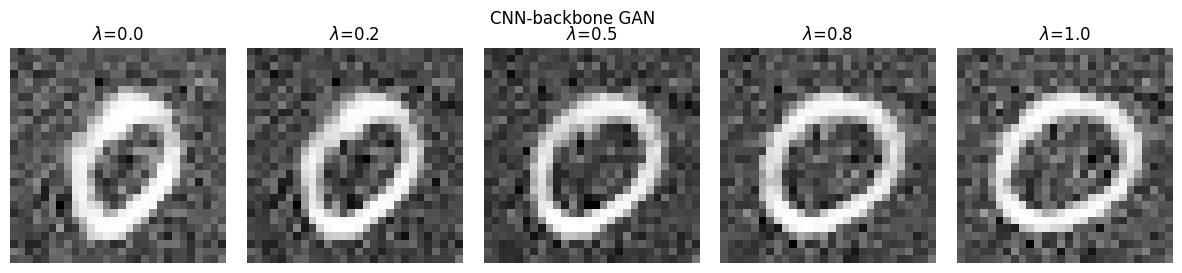

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.suptitle('CNN-backbone GAN')
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

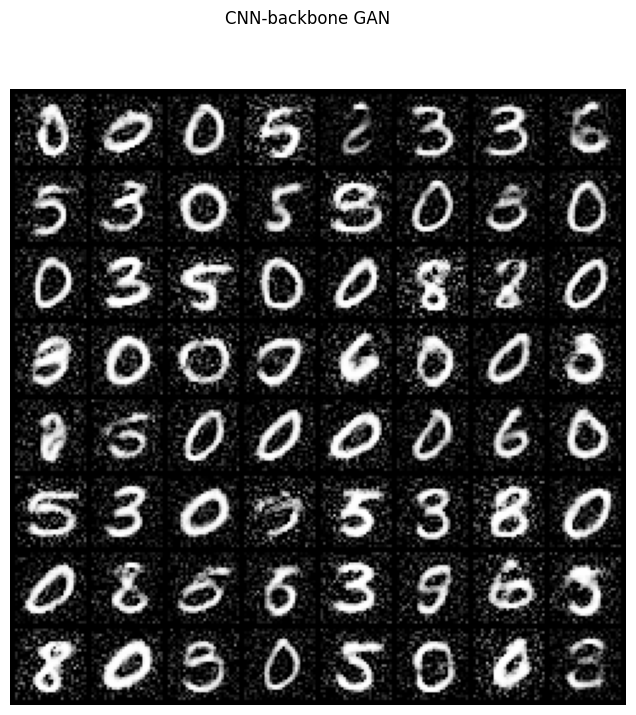

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.suptitle('CNN-backbone GAN')
    plt.show()

A CNN as Backbone
-----------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters. Running this will shadow the alternative vanilla version above. You will still need to instantiate it.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

Don't hesitate to tweak the architecture to improve it.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, latent_dim * 32, 5, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(latent_dim * 32)
        self.deconv2 = nn.ConvTranspose2d(latent_dim * 32, latent_dim * 16, 5, 1, 1)
        self.deconv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.deconv3 = nn.ConvTranspose2d(latent_dim * 16, latent_dim, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(latent_dim)
        self.deconv4 = nn.ConvTranspose2d(latent_dim, 1, 4, 2, 1)

    def forward(self, x):
        x = x[:, :, None, None]
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, latent_dim, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(latent_dim)
        self.conv2 = nn.Conv2d(latent_dim, latent_dim * 16, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.conv3 = nn.Conv2d(latent_dim * 16, latent_dim * 32, 5, 1, 1)
        self.conv3_bn = nn.BatchNorm2d(latent_dim * 32)
        self.conv4 = nn.Conv2d(latent_dim * 32, latent_dim, 5, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(latent_dim)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.fc(self.flatten(x)))
        return x

Again, you can save and load the trained weights.

In [ ]:
torch.save(generator.state_dict(), 'my_cnn_gan_generator.pth')
torch.save(discriminator.state_dict(), 'my_cnn_gan_discriminator.pth')

In [ ]:
generator.load_state_dict(torch.load('my_cnn_gan_generator.pth'))
discriminator.load_state_dict(torch.load('my_cnn_gan_discriminator.pth'))

<All keys matched successfully>

You can now have a look at the results of the model by running again the corresponding sections.